# Simple Pose Estimation to draw on checkerboard
Do a simple pose estimation of a checkerboard and draw a coordinate system on the surface

In this examle:
1. Use camera calibarion data from CalibrateCamera.ipynb
2. Find chessboard corners 
3. Use solvePnPRansac to determine the rotation and translation of the checkerboard from the camera
* We know the points on the checkerboard are all planar, and we know the real world distances betweeen them (which can be in either real units, or in units of 'checkerboard square width')
4. Project set of 3d points onto the image using projectPoints. This gvies us the 2d image coordinates of the 3d object
5. Draw the points on the image


Following: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html#pose-estimation

In [1]:
import os
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt

Found 22 images


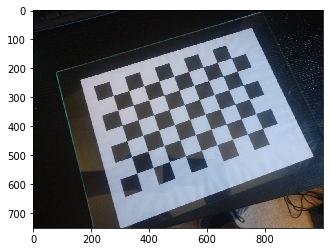

In [2]:
image_dir = "images/checkerboard/"
image_scale = 0.25
image_names = [os.path.join(image_dir,fname) for fname in os.listdir(image_dir)]
print(f"Found {len(image_names)} images")
images = [cv2.imread(fname) for fname in image_names]
if image_scale != 1:
    images = [cv2.resize(image,(0,0),fx=image_scale,fy=image_scale) for image in images]
plt.imshow(images[0][:,:,::-1])
plt.show()

In [3]:
parameter_filename = f"camera_parameters_scale{image_scale:.4f}.json"
with open(parameter_filename,'r') as fp:
    parameters = json.load(fp)

mtx = np.array(parameters['mtx'],dtype=np.float32)
newCameraMtx = np.array(parameters['newCameraMtx'],dtype=np.float32)
dist = np.array(parameters['dist'],dtype=np.float32)
roi = np.array(parameters['roi'],dtype=np.float32)

In [4]:
def draw(img, corners, imgpts):
    '''
    img: The image to draw on
    imgpts: The images coordintes of the center of the coordinate system
    
    '''
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (0,0,255), 5) #colors are b,g,r
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (255,0,0), 5)
    return img

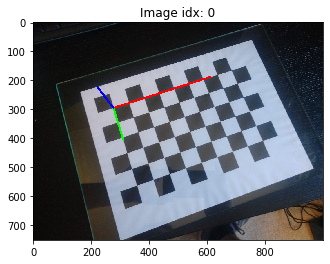

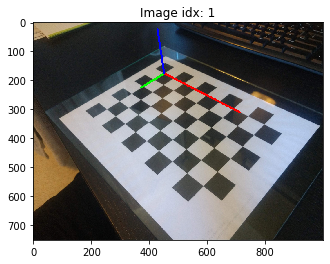

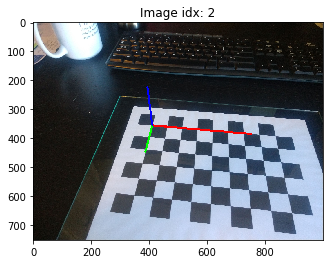

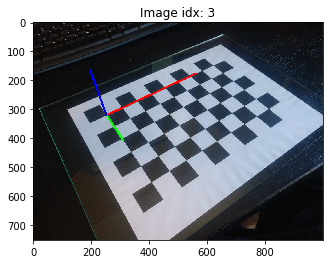

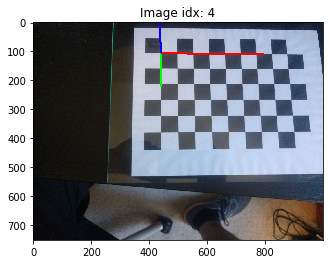

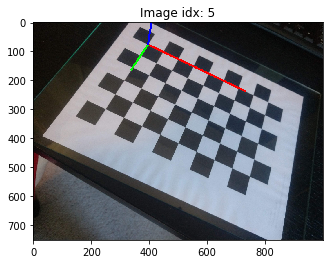

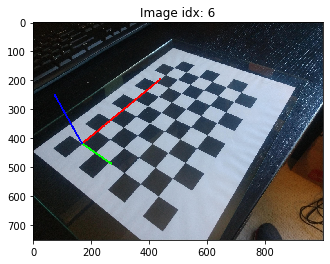

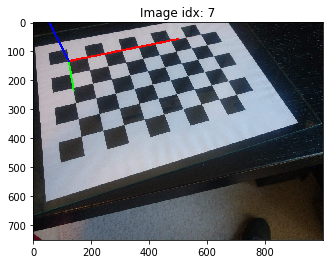

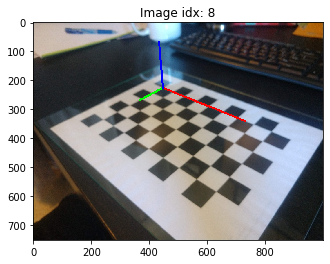

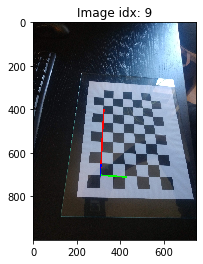

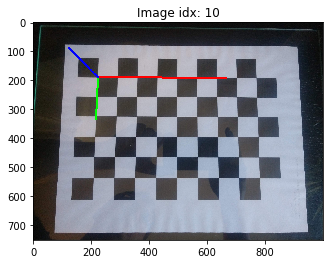

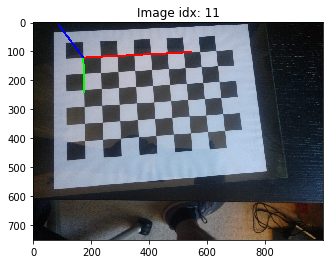

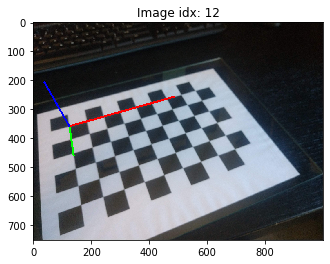

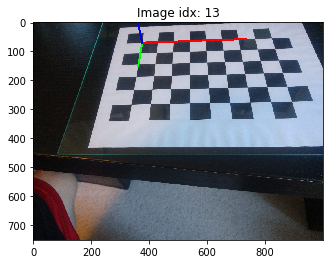

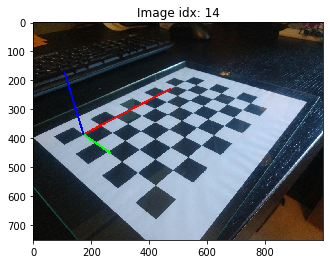

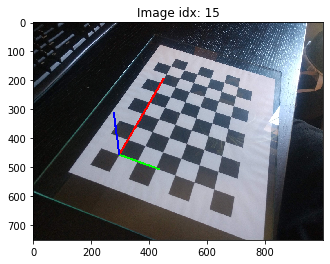

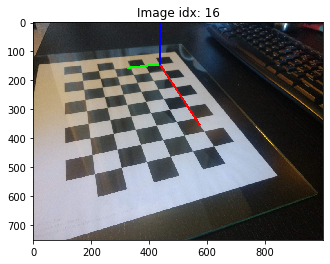

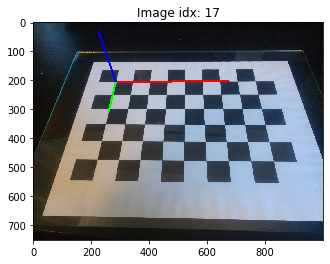

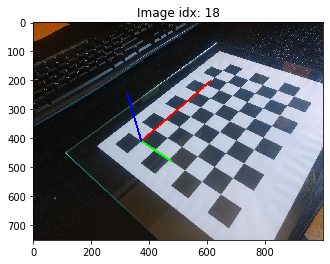

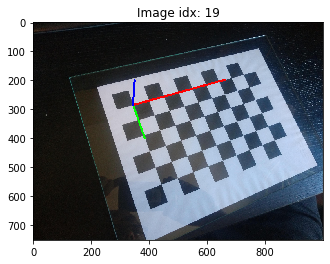

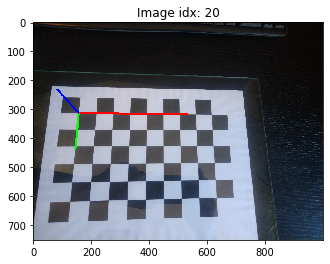

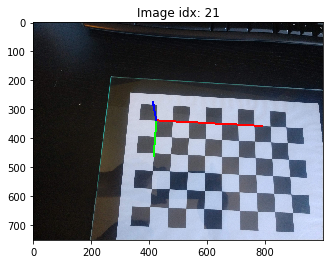

In [5]:
gridSize = (9,6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objPoint = np.zeros((gridSize[0]*gridSize[1],3), np.float32)
objPoint[:,:2] = np.mgrid[0:gridSize[0],0:gridSize[1]].T.reshape(-1,2)

# The object points are in checkerboard units where 1 square = 1 unit
# If we know how large the actual squares are, we can scale the 
#   the object points by it 
objPoint = objPoint * (5.55/6) # 6 squares are 5.55 inches long

# These are the 'end points' of each line
# The corner that is identified on the checkerboard is the start point
axis = np.float32([[6,0,0], [0,2,0], [0,0,-3]]).reshape(-1,3)


for image_idx, image in enumerate(images):
    #image = images[3]
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, gridSize,None)

    if ret == True:
        # refine points
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors
        # Uses ransac to determine how the ojbect is rotated when the 
        #   coordinates of the corners are known
        ret, rvecs, tvecs, inliers = cv2.solvePnPRansac(objPoint, corners2, mtx, dist)

        # project 3D points to image plane
        # imgPoints are the locations of the 3d points projected onto the checkerboard
        #    in image coordinates
        imgPoints, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        image_with_drawing = image.copy()
        image_with_drawing = draw(image_with_drawing, corners2, imgPoints)
        plt.title(f"Image idx: {image_idx}")
        plt.imshow(image_with_drawing[:,:,::-1])
        plt.show()


In [6]:
def drawLines(img, startPoints, endPoints,color=(0,0,255),thickness=5):
    '''
    Draw lines between the corresponding startPoint and endPoint on img
    '''
    for sp, ep in zip(startPoints,endPoints):
        img = cv2.line(img, tuple(sp.ravel()), tuple(ep.ravel()), color=color, thickness=thickness) #colors are b,g,r
    return img        

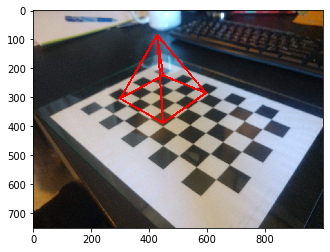

In [7]:
# Now draw something a little more interesting
# start and end points for each line segment
startPoints = np.array([[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,0,0],[1,0,0],[1,1,0],[0,1,0]],dtype=np.float32).reshape(-1,3)
endPoints = np.array([[1,0,0],[1,1,0],[0,1,0],[0,0,0],[.5,.5,-1],[.5,.5,-1],[.5,.5,-1],[.5,.5,-1]],dtype=np.float32).reshape(-1,3)

# Scale the points
startPoints = startPoints*3.5
endPoints = endPoints*3.5

image = images[8]
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, gridSize,None)

if ret == True:
    # refine points
    corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

    # Find the rotation and translation vectors
    # Uses ransac to determine how the ojbect is rotated when the 
    #   coordinates of the corners are known
    ret, rvecs, tvecs, inliers = cv2.solvePnPRansac(objPoint, corners2, mtx, dist)

    # project 3D points to image plane
    # imgPoints are the locations of the 3d points projected onto the checkerboard
    #    in image coordinates
    startPointsProjected, jac = cv2.projectPoints(startPoints, rvecs, tvecs, mtx, dist)
    endPointsProjected, jac = cv2.projectPoints(endPoints, rvecs, tvecs, mtx, dist)

    image_with_drawing = image.copy()
    image_with_drawing = drawLines(image_with_drawing, startPointsProjected, endPointsProjected)
    plt.imshow(image_with_drawing[:,:,::-1])
    plt.show()
